In [2]:
%%capture
!pip install timm
!pip install -U albumentations

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!mkdir midsw251birds
!unzip drive/MyDrive/W251/hw7/midsw251birds.zip -d midsw251birds

In [ ]:
!ls -l midsw251birds

total 2580
-rw-r--r-- 1 root root    5062 Jun  7 16:49 metadata.csv
-rw-r--r-- 1 root root  197871 Jun  7 16:49 sample_submission.csv
drwxr-xr-x 2 root root  270336 Jun 25 18:41 test
-rw-r--r-- 1 root root  181377 Jun  7 16:49 test.csv
drwxr-xr-x 2 root root 1097728 Jun 25 18:41 train
-rw-r--r-- 1 root root  876817 Jun  7 16:49 train.csv


In [3]:
import os
import time
from tqdm import tqdm_notebook as tqdm
#import tqdm.notebook import tqdm
import cv2
from PIL import Image
import numpy as np
import pandas as pd
import torch
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import DataLoader, Dataset
from torch.optim import lr_scheduler
import timm
import warnings
import math

import matplotlib.pyplot as plt

from torch.utils.tensorboard import SummaryWriter

from timm.scheduler.cosine_lr import CosineLRScheduler
from timm.scheduler.step_lr import StepLRScheduler
from torch.cuda.amp import autocast, GradScaler

warnings.filterwarnings('ignore')

In [ ]:
class args:
    lr = 1e-2
    epochs = 20
    batch_size = 48
    num_workers = 8
    folds = 5
    n_warmup_epochs = 1

In [ ]:
alldf = pd.read_csv('midsw251birds/train.csv')
# Split the training dataset into a training and a validation
valdf = alldf[::args.folds]
trndf = alldf[~alldf.filename.isin(valdf.filename)]
# Load our test data
tstdf = pd.read_csv('midsw251birds/test.csv')
metadf = pd.read_csv('midsw251birds/metadata.csv')
metadf = metadf.set_index('label')
print(f'File shapes -- train : {trndf.shape}, valid : {valdf.shape}, test : {tstdf.shape}')
trndf.head()

File shapes -- train : (26379, 2), valid : (6595, 2), test : (8244, 1)


,filename,label
1,train/bb99f4bea973.jpg,147
2,train/50923ceb3ffd.jpg,147
3,train/f9fc3c6da5d7.jpg,147
4,train/dfe8cb1855fe.jpg,147
6,train/4fe53a096533.jpg,147


In [ ]:
imgnetmeans = [0.22363983, 0.18190407, 0.2523437 ]
imgnetstds = [0.32451536, 0.2956294,  0.31335256]
# Using albumentations, check some examples here : https://albumentations.readthedocs.io/en/latest/examples.html 
def trntransforms():
    return A.Compose([
        A.HorizontalFlip(p=0.5),
        A.Transpose(p=0.5),
        ToTensorV2(),
        ])

def tsttransforms():
    return A.Compose([
        ToTensorV2(),
    ])

class BirdDataset(Dataset):
    def __init__(self, df, mode, transform=None):
        self.data = df
        self.img_dir = 'midsw251birds/'
        self.transform = transform
        self.mode = mode

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        
        fname = self.data.iloc[idx]['filename']
        img_path = f'{self.img_dir}/{fname}'
        image = cv2.imread(img_path)
        if self.transform is not None:
            image = self.transform(image = image)['image']
        image = image.float() / 255.
        label = -1 if self.mode=='test' else self.data.iloc[idx]['label']
        
        return image, label

In [ ]:
# Define our dataset
trndataset = BirdDataset(trndf, 'train', trntransforms())
valdataset = BirdDataset(valdf, 'valid', tsttransforms())
tstdataset = BirdDataset(tstdf, 'test', tsttransforms())

Species : KOOKABURRA


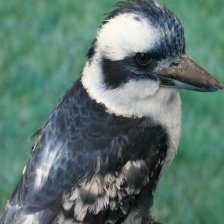

In [ ]:
# Test the dataset
img, label = next(iter(trndataset))
species = metadf.loc[label]['name']
print(f'Species : {species}')
#Image.fromarray(img)
imgviz = (img * 255).transpose(0, 2).numpy().astype(np.uint8)
Image.fromarray(imgviz)

In [ ]:
loaderargs = {'num_workers' : args.num_workers, 'batch_size':args.batch_size, 'pin_memory': False, 'drop_last': False}
trnloader = DataLoader(trndataset, shuffle = True, **loaderargs)
valloader = DataLoader(valdataset, shuffle = False, **loaderargs)
tstloader = DataLoader(tstdataset, shuffle = False, **loaderargs)

In [ ]:
# List the TIMM models if you want to see them all
#timm.list_models(pretrained=True)

In [4]:
model = timm.create_model('swin_base_patch4_window7_224', pretrained = True, num_classes=270)

Downloading: "https://github.com/SwinTransformer/storage/releases/download/v1.0.0/swin_base_patch4_window7_224_22kto1k.pth" to /root/.cache/torch/hub/checkpoints/swin_base_patch4_window7_224_22kto1k.pth


In [1]:
# if you want to see all the layer names
# params = model.state_dict()
# params.keys()

In [ ]:
# freeze everything below layers2.16
for name, param in model.named_parameters():
  if param.requires_grad and 'head' not in name and not name.startswith('norm') and 'layers.3.blocks' not in name and 'layers.2.downsample' not in name and 'layer2.blocks.17' not in name and 'layer2.blocks.16' not in name:
    param.requires_grad = False

In [ ]:
# Move model to GPU
device = torch.device("cuda:0")
model = model.to(device)
# I had better luck w/ SGD than adam ¯\_(ツ)_/¯
optimizer = torch.optim.SGD(model.parameters(), lr=args.lr, momentum=0.9)

num_epochs = args.epochs
num_steps = len(trnloader)

# 2 cycle CosineLR
scheduler = CosineLRScheduler(
            optimizer,
            t_initial= num_steps * (num_epochs // 2) + 1,
            lr_min=5e-4,
            warmup_lr_init=5e-4,
            warmup_t= num_steps * args.n_warmup_epochs + 1)


In [ ]:
class LabelSmoothingLoss(torch.nn.Module):
    def __init__(self, classes, smoothing=0.0, dim=-1):
        super(LabelSmoothingLoss, self).__init__()
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.cls = classes
        self.dim = dim

    def forward(self, pred, target):
        pred = pred.log_softmax(dim=self.dim)
        with torch.no_grad():
            # true_dist = pred.data.clone()
            true_dist = torch.zeros_like(pred)
            true_dist.fill_(self.smoothing / (self.cls - 1))
            true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        return torch.mean(torch.sum(-true_dist * pred, dim=self.dim))

In [ ]:
# label smoothing at 0.08
criterion = LabelSmoothingLoss(270, 0.08)

In [ ]:
# Creates a GradScaler once at the beginning of training.
scaler = GradScaler()

In [ ]:
def train(model, checkpoint_suffix):
  since = time.time()
  writer = SummaryWriter()
  global_step = 0
  beta=1.0
  best_val = 0
  if not os.path.exists(f'checkpoints_folder_{checkpoint_suffix}'):
    os.mkdir(f'checkpoints_folder_{checkpoint_suffix}')

  for epoch in range(num_epochs):
      print('Epoch {}/{}'.format(epoch, num_epochs - 1))
      model.train()
      running_loss = 0.0
      tk0 = tqdm(trnloader, total=int(len(trnloader)))
      for step, batch in enumerate(tk0):
          scheduler.step(global_step)
          writer.add_scalar("LR", optimizer.param_groups[0]['lr'], global_step)
          global_step += 1

          # Do a pass through the images w/o mixup
          inputs = batch[0].to(device, dtype=torch.float)
          labels = batch[1].to(device).long()

          optimizer.zero_grad()
          # AMP
          with autocast():
            outputs = model(inputs)
            loss = criterion(outputs, labels)

          writer.add_scalar("Loss/train", loss, epoch)
          scaler.scale(loss).backward()
          scaler.step(optimizer)
          # Updates the scale for next iteration.
          scaler.update()
          running_loss += loss.item()
          tk0.set_postfix(train_loss=(running_loss / (step+1)))

          # Do another pass with mixup
          lam = np.random.beta(beta, beta)
          rand_index = torch.randperm(inputs.size()[0]).to(device) # make an index which reorders the batch
          
          # Reorder the labels
          labels_a = labels
          labels_b = labels[rand_index]
          
          # Partially mixup up the batch
          inputs_mixed = lam * inputs + (1 - lam) * inputs[rand_index]

          optimizer.zero_grad()
          # AMP
          with autocast():
            output = model(inputs_mixed)
            loss = criterion(output, labels_a) * lam + criterion(output, labels_b) * (1. - lam)
          
          writer.add_scalar("Loss/train-mixed", loss, epoch)
          scaler.scale(loss).backward()
          scaler.step(optimizer)
          # Updates the scale for next iteration.
          scaler.update()
          running_loss += loss.item()
          tk0.set_postfix(train_loss=(running_loss / (step+1)))
          
      valpreds = []
      model.eval()
      running_loss = 0.0
      tkval = tqdm(valloader, total=int(len(valloader)))
      for step, batch in enumerate(tkval):
          inputs = batch[0].to(device, dtype=torch.float)
          labels = batch[1].to(device).long()
          with torch.no_grad():
              outputs = model(inputs)
              loss = criterion(outputs, labels)
              writer.add_scalar("Loss/valid", loss, epoch)
          valpreds .append(outputs)
          running_loss += loss.item()
          tkval.set_postfix(valid_loss=(running_loss / (step+1)))
      preds = torch.cat(valpreds).argmax(1).detach().cpu().numpy()
      print(f'Valid accuracy {(valdf.label.values == preds).mean():.4f}')
      torch.save({
              'epoch': epoch,
              'model_state_dict': model.state_dict(),
              'optimizer_state_dict': optimizer.state_dict(),
              'loss': loss,
              }, f'./checkpoints_folder_{checkpoint_suffix}/checkpoint_{epoch}')
      if (valdf.label.values == preds).mean() > best_val:
          torch.save({
          'epoch': epoch,
          'model_state_dict': model.state_dict(),
          'optimizer_state_dict': optimizer.state_dict(),
          'loss': loss,
          }, f'./checkpoints_folder_{checkpoint_suffix}/checkpoint_best')
          best_val = (valdf.label.values == preds).mean()

In [ ]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir runs

In [ ]:
train(model,'swin_head_norm_blocks3-2')

Epoch 0/19



Valid accuracy 0.9407
Epoch 1/19



Valid accuracy 0.9633
Epoch 2/19



Valid accuracy 0.9625
Epoch 3/19



Valid accuracy 0.9713
Epoch 4/19



Valid accuracy 0.9766
Epoch 5/19



Valid accuracy 0.9739
Epoch 6/19



Valid accuracy 0.9776
Epoch 7/19



Valid accuracy 0.9788
Epoch 8/19



Valid accuracy 0.9771
Epoch 9/19



Valid accuracy 0.9792
Epoch 10/19



Valid accuracy 0.9807
Epoch 11/19



Valid accuracy 0.9806
Epoch 12/19



Valid accuracy 0.9813
Epoch 13/19



Valid accuracy 0.9815
Epoch 14/19



Valid accuracy 0.9820
Epoch 15/19



Valid accuracy 0.9817
Epoch 16/19



Valid accuracy 0.9817
Epoch 17/19



Valid accuracy 0.9815
Epoch 18/19



Valid accuracy 0.9817
Epoch 19/19



Valid accuracy 0.9821


In [ ]:
!cp -r 'checkpoints_folder_swin_head_norm_blocks3-2' drive/MyDrive/W251/hw7/

In [ ]:
test_model = model

In [ ]:
# get weights from best run
test_checkpoint = torch.load('checkpoints_folder_swin_head_norm_blocks3-2/checkpoint_best')
test_model.load_state_dict(test_checkpoint['model_state_dict'])

In [ ]:


# Submit 
tstpreds = []
tktst = tqdm(tstloader, total=int(len(tstloader)))
for step, batch in enumerate(tktst):
    inputs = batch[0].to(device, dtype=torch.float)
    with torch.no_grad():
        outputs = test_model(inputs)
        tstpreds.append(outputs)
predicted_labels = torch.cat(tstpreds).argmax(1).detach().cpu().numpy()
tstdf['label'] = predicted_labels



In [ ]:
tstdf.to_csv('submission_swin_2.csv', index = False)

In [ ]:
!cp submission_swin_2.csv drive/MyDrive/W251/hw7/